# RAPIDS & Scanpy Single-Cell RNA-seq Multi-GPU Workflow on 1 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. We then use dask to scale PCA, K-means clustering, and UMAP across multiple GPUs.

See the README for instructions to download this dataset.

## Import requirements

In [1]:
import time
import pandas as pd
import numpy as np
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cupy as cp
import cupyx as cpx
import cupyx

import cudf
import math


import h5py
import scipy

import dask
import dask_cudf
import rmm

from numba import cuda
from statsmodels import robust

from dask_cuda import initialize, LocalCUDACluster
from dask import delayed, dataframe
from dask.dataframe.utils import make_meta
from dask.distributed import Client, default_client
from dask_cuda.local_cuda_cluster import cuda_visible_devices
import dask.dataframe as dd

from cuml.common.memory_utils import with_cupy_rmm
from cuml.common import rmm_cupy_ary
from cuml.manifold import TSNE, UMAP
from cuml.linear_model import LinearRegression

from cuml.dask.decomposition import PCA as cu_dask_PCA
from cuml.dask.cluster import KMeans as cu_dask_KMeans
from cuml.dask.manifold import UMAP as cu_dask_UMAP
from cuml.dask.linear_model import LinearRegression as cu_dask_LinearRegression
from cuml.dask.neighbors import NearestNeighbors as cu_dask_NearestNeighbors

from cuml.dask.common.dask_arr_utils import to_dask_cudf, to_sparse_dask_array
from cuml.dask.common.dask_df_utils import to_dask_cudf
from cuml.dask.common.input_utils import to_dask_cupy
from cuml.dask.common.part_utils import _extract_partitions

from bokeh.io.export import export_png
from bokeh.plotting import figure
from bokeh.models.tickers import FixedTicker
from bokeh.io import output_notebook, push_notebook, show

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

output_notebook()

COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941",
          "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC",
          "#B79762", "#004D43", "#8FB0FF", "#997D87", "#5A0007", "#809693",
          "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
          "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", 
          "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299",
          "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500",
          "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
          "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68",
          "#7A87A1", "#788D66", "#885578", "#FAD09F", "#FF8A9A", "#D157A0",
          "#BEC459", "#456648", "#0086ED", "#886F4C", "#34362D", "#B4A8BD",
          "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
          "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757",
          "#C8A1A1", "#1E6E00", "#7900D7", "#A77500", "#6367A9", "#A05837",
          "#6B002C", "#772600", "#D790FF", "#9B9700", "#549E79", "#FFF69F",
          "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
          "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804",
          "#324E72", "#6A3A4C",]

Loading BokehJS ...

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory

In [2]:
cluster_start = time.time()

enable_tcp_over_ucx = True
enable_nvlink = True
enable_infiniband = True
CUDA_VISIBLE_DEVICES = cuda_visible_devices(0).split(',')
CUDA_VISIBLE_DEVICES = [1, 2, 3, 4, 5, 6, 7]

rmm.reinitialize(managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

initialize.initialize(create_cuda_context=True,
                      enable_tcp_over_ucx=enable_tcp_over_ucx,
                      enable_nvlink=enable_nvlink,
                      enable_infiniband=enable_infiniband)

cluster = LocalCUDACluster(protocol="ucx",
                           dashboard_address=':9001',
                           CUDA_VISIBLE_DEVICES=CUDA_VISIBLE_DEVICES,
                           enable_tcp_over_ucx=enable_tcp_over_ucx,
                           enable_nvlink=enable_nvlink,
                           enable_infiniband=enable_infiniband)

client = Client(cluster)
client.run(cp.cuda.set_allocator)
n_workers = len(client.scheduler_info()['workers'].keys())
client

Client Scheduler: ucx://127.0.0.1:52545 Dashboard: http://127.0.0.1:9001/status,Cluster Workers: 7 Cores: 7 Memory: 540.95 GB


## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
import os, wget

input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download(
        'https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
        input_file)

## Set parameters

In [4]:
# marker genes
MITO_GENE_PREFIX = "mt-"              # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"]  # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200      # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000     # Filter out cells with more genes than this expressed 
min_cells=1                   # Genes containing a number of cells below this value will be filtered

# filtering genesinitialize
n_top_genes = 4000            # Number of highly variable genes to retain

# PCA
n_components = 50             # Number of principal components to compute
pca_train_ratio = 0.35        # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20               # Number of principal components to use for t-SNE

# k-means
k = 35                        # Number of clusters for k-means

# KNN
n_neighbors = 15              # Number of nearest neighbors for KNN graph
knn_n_pcs = 50                # Number of principal components to use for finding nearest neighbors

# UMAP
umap_train_ratio = 0.35
umap_min_dist = 0.3
umap_spread = 1.0

MAX_RECS = -1            # To filter first x numbers of rows. Please change it to -1 for using all
BATCHSIZE = 20000

start_time = time.time()

## Load and Prepare Data

## We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [5]:
time_data_load = time.time()

In [6]:
%%time

@delayed
def read_partition(sample_file, ds_data, ds_indices, ds_indptr, 
                   batch_start, rows, total_cols, gene_filter,
                   min_genes_per_cell=200, max_genes_per_cell=6000, target_sum=1e4):
    """
    Loads a single partition from HDF5 file.
    """
    batch_end = batch_start + rows

    with h5py.File(input_file, 'r') as h5f:
        # Read all things row pointers for one worker
        indptrs = h5f[ds_indptr]
        start_ptr = indptrs[batch_start]
        end_ptr = indptrs[batch_end]

        # Read all things data for one worker
        data = h5f[ds_data]
        sub_data = cp.array(data[start_ptr:end_ptr])

        # Read all things column pointers for one worker
        indices = h5f[ds_indices]
        sub_indices = cp.array(indices[start_ptr:end_ptr])

        # recompute the row pointer for the partial dataset
        sub_indptrs  = cp.array(indptrs[batch_start:(batch_end + 1)])
        first_ptr = sub_indptrs[0]
        sub_indptrs = sub_indptrs - first_ptr

    partial_sparse_array = cp.sparse.csr_matrix((sub_data, sub_indices, sub_indptrs),
                                                shape=(batch_end - batch_start, total_cols))

    # TODO: Add barcode filtering here.
    degrees = cp.diff(partial_sparse_array.indptr)
    query = ((min_genes_per_cell <= degrees) & (degrees <= max_genes_per_cell))
    partial_sparse_array = partial_sparse_array[query]
    partial_sparse_array = rapids_scanpy_funcs.normalize_total(
        partial_sparse_array, target_sum=target_sum)

    if not gene_filter:
        partial_sparse_sq_array = partial_sparse_array.power(2)
        col1 = partial_sparse_array.sum(axis=0)
        col2 = partial_sparse_sq_array.sum(axis=0)
        ret_value = cp.hstack([col1, col2])
        del partial_sparse_sq_array

    else:
        ret_value = partial_sparse_array[:, gene_filter]

    del partial_sparse_array
    return ret_value

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 245 µs


In [7]:
%%time

# Read along with filtering
with h5py.File(input_file, 'r') as h5f:
    indptr = h5f['/X/indptr']
    data = h5f['/X/data']
    orginal_genes = h5f['/var/_index']
    
    orginal_genes = cudf.Series(orginal_genes, dtype=cp.dtype('object'))

    total_cols = orginal_genes.shape[0]
    total_rows = indptr.shape[0] - 1

if MAX_RECS == -1:
    MAX_RECS = total_rows

print('Computing sum and creating gene count filter...')
dls_sum = []
for batch_start in range(0, MAX_RECS, BATCHSIZE):
    batch_size = BATCHSIZE if MAX_RECS > batch_start + BATCHSIZE else MAX_RECS - batch_start
    dls_sum.append(
        dask.array.from_delayed(
            (read_partition)(input_file, 
                           '/X/data', '/X/indices', '/X/indptr', 
                           batch_start, batch_size, total_cols, None,
                           min_genes_per_cell=min_genes_per_cell,
                           max_genes_per_cell=max_genes_per_cell),
            dtype=cp.float32,
            shape=(batch_size, total_cols * 2)))

# First half of this array is sum and rest is square of sum
sum_gpu_arrays  = dask.array.concatenate(dls_sum).compute()

# Split the sum and square
sum_gpu_array = sum_gpu_arrays[:, 0:sum_gpu_arrays.shape[1]/2]
sum_sq_gpu_array = sum_gpu_arrays[:,sum_gpu_arrays.shape[1]/2:]

# Filter genes with at-least <<min_cells>> number of cells rec.
sum_gpu_array = sum_gpu_array.sum(axis=0)
min_cell_filter = (sum_gpu_array >= min_cells)

sum_gpu_array = sum_gpu_array[min_cell_filter]
sum_sq_gpu_array = sum_sq_gpu_array[:, min_cell_filter]
sum_sq_gpu_array = sum_sq_gpu_array.sum(axis=0)

Computing sum and creating gene count filter...
CPU times: user 8.34 s, sys: 1.84 s, total: 10.2 s
Wall time: 46.7 s


In [8]:
%%time

print('Loading data into dataframes...')
dls_data = []
for batch_start in range(0, MAX_RECS, BATCHSIZE):
    batch_size = BATCHSIZE if MAX_RECS > batch_start + BATCHSIZE else MAX_RECS - batch_start

    dls_data.append(
        dask.array.from_delayed(
            (read_partition)(input_file,
                           '/X/data', '/X/indices', '/X/indptr', 
                           batch_start, batch_size, total_cols, min_cell_filter.tolist(),
                           min_genes_per_cell=min_genes_per_cell,
                           max_genes_per_cell=max_genes_per_cell),
            dtype=cp.float32,
            shape=(batch_size, sum_sq_gpu_array.shape[0])))

print('Concate sub-arrays...')
sparse_gpu_array = dask.array.concatenate(dls_data)
sparse_gpu_array = sparse_gpu_array.persist()
sparse_gpu_array

Loading data into dataframes...
Concate sub-arrays...
CPU times: user 10.1 s, sys: 148 ms, total: 10.2 s
Wall time: 10.1 s


dask.array<concatenate, shape=(1306127, 23862), dtype=float32, chunksize=(20000, 23862), chunktype=numpy.ndarray>

In [9]:
# genes = orginal_genes[min_cell_filter]
# sum_sq_gpu_array/MAX_RECS, sum_gpu_array, genes

For this example, we select the first 1 million cells in the dataset. We maintain the index of unique genes in our dataset:

Verify the shape of the resulting sparse matrix:

In [10]:
%%time
sparse_gpu_array = dask.array.log1p(sparse_gpu_array)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 788 µs


And the number of non-zero values in the matrix:

In [11]:
time_data_load = time.time() - time_data_load
print("Total data load and Filtering: %s" % time_data_load)

Total data load and Filtering: 56.874629497528076


## Preprocessing

In [12]:
preprocess_start = time.time()

### Filter

In [13]:
# Filter out the genes that got removed from the original data
genes = orginal_genes[min_cell_filter]
genes.shape

(23862,)

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [14]:
%%time
# FILTERING IS NOT DONE WHILE READING DATA
# sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, 
#                                                     min_genes=min_genes_per_cell, 
#                                                     max_genes=max_genes_per_cell)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


Some genes will now have zero expression in all cells. We filter out such genes.

In [15]:
%%time
# FILTERING IS NOT DONE WHILE READING DATA
# sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes.get(), min_cells=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


The size of our count matrix is now reduced.

In [16]:
%%time
# sparse_gpu_array.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
# This is now done while loading data
# sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)
# sparse_gpu_array = sparse_gpu_array.log1p()

# sparse_gpu_array = sparse_gpu_array.astype(cp.float32)
# sparse_gpu_array.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


Next, we log transform the count matrix.

In [18]:
%%time

time_marker_highly_variable = time.time()

marker_genes_raw = {}
genes1 = genes.reset_index(drop=True)
i = 0
for index in genes1[genes1.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = sparse_gpu_array[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 3.19 s, sys: 620 ms, total: 3.81 s
Wall time: 21.3 s


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [19]:
%%time
# gpu_array = sparse_gpu_array.compute()
# adata = anndata.AnnData(gpu_array.get())
# adata.var_names = genes.to_pandas()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

Using scanpy, we filter the count matrix to retain only the most variable genes.

In [20]:
%%time
# sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
# print("Full time: %s" % (time.time() - start))
# sc_hightly_variable = genes[adata.var.highly_variable.values]
# sc_hightly_variable.head(10)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.5 µs


In [21]:
%%time

mean = sum_gpu_array / sparse_gpu_array.shape[0]
mean[mean == 0] = 1e-12

mean_sq = sum_sq_gpu_array / sparse_gpu_array.shape[0]
variance = mean_sq - mean ** 2
variance *= sparse_gpu_array.shape[1] / (sparse_gpu_array.shape[0] - 1) 
dispersion = variance / mean

df = pd.DataFrame()
df['genes'] = genes.to_array()
df['means'] = mean.tolist()
df['dispersions'] = dispersion.tolist()
df['mean_bin'] = pd.cut(
    df['means'],
    np.r_[-np.inf, np.percentile(df['means'], np.arange(10, 105, 5)), np.inf],
)

disp_grouped = df.groupby('mean_bin')['dispersions']
disp_median_bin = disp_grouped.median()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    disp_mad_bin = disp_grouped.apply(robust.mad)
    df['dispersions_norm'] = (
        df['dispersions'].values - disp_median_bin[df['mean_bin'].values].values
    ) / disp_mad_bin[df['mean_bin'].values].values

dispersion_norm = df['dispersions_norm'].values

dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
dispersion_norm[::-1].sort()

if n_top_genes > df.shape[0]:
    n_top_genes = df.shape[0]

disp_cut_off = dispersion_norm[n_top_genes - 1]
vaiable_genes = np.nan_to_num(df['dispersions_norm'].values) >= disp_cut_off

genes = genes[vaiable_genes]

# Filter highly variable genes
dask_array = sparse_gpu_array[:, vaiable_genes]

time_marker_highly_variable = time.time() - time_marker_highly_variable
print("Highly variable genes: %s" % time_marker_highly_variable)
genes.shape

Highly variable genes: 21.68018865585327
CPU times: user 168 ms, sys: 12 ms, total: 180 ms
Wall time: 171 ms


(4000,)

### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [22]:
%%time
time_regress_out = time.time()

@with_cupy_rmm
def csr_to_csc(csr_array, client):
    def _conv_csr_to_csc(x):
        return  x.tocsc()

    parts = client.sync(_extract_partitions, csr_array)
    futures = [client.submit(_conv_csr_to_csc, 
                             part, 
                             workers=[w], 
                             pure=False)
               for w, part in parts]
    objs = []
    shape = csr_array.shape
    for i in range(len(futures)):
        obj = dask.array.from_delayed(futures[i], 
                                      shape=futures[i].result().shape,
                                      dtype=cp.float32)
        objs.append(obj)
    return dask.array.concatenate(objs)

sparse_gpu_array = csr_to_csc(dask_array, client=client)
sparse_gpu_array = sparse_gpu_array.persist()
sparse_gpu_array.shape

CPU times: user 16.9 s, sys: 8.86 s, total: 25.7 s
Wall time: 32 s


(1291337, 4000)

In [23]:
%%time

@with_cupy_rmm
def sum_csc(csc_array, client):

    shape = csc_array.shape
    def __sum(x):
        return x.sum(axis=1)

    parts = client.sync(_extract_partitions, csc_array)
    futures = [client.submit(__sum, 
                             part, 
                             workers=[w], 
                             pure=False)
               for w, part in parts]
    objs = []
    for i in range(len(futures)):
        obj = dask.array.from_delayed(futures[i], 
                                      shape=futures[i].result().shape,
                                      dtype=cp.float32)
        objs.append(obj)
    return dask.array.concatenate(objs)

mito_genes = genes.str.startswith(MITO_GENE_PREFIX)
mito_genes = cp.fromDlpack(mito_genes.to_dlpack())
mito_genes_indices = cp.where(mito_genes == 1)[0]

# # n_counts = dask.array.sum(sparse_gpu_array, axis=1, keepdims=False)
n_counts = sum_csc(sparse_gpu_array, client=client)
n_counts = dask.array.sum(n_counts, axis=1).compute()

result = dask.array.take(sparse_gpu_array,
                         mito_genes_indices.tolist(),
                         axis=1)
result = sum_csc(result, client=client)
result = dask.array.sum(result, axis=1)
result = dask.array.true_divide(result, n_counts)
# result.compute()

percent_mito = dask.array.ravel(result)
percent_mito = percent_mito.compute()
del result

CPU times: user 1.51 s, sys: 276 ms, total: 1.78 s
Wall time: 5.62 s


And perform regression:

In [24]:
%%time
# dk_sparse_gpu_array = dask.array.from_array(sparse_gpu_array, chunks=chunk_size, asarray=False)
regressors = cp.ones((n_counts.shape[0]*3), dtype=cp.float32).reshape((n_counts.shape[0], 3), order="F")
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

X = dask.array.from_array(regressors, asarray=False)
del regressors
del n_counts
X.shape

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.78 ms


(1291337, 3)

In [25]:
%%time

# sparse_gpu_array = rapids_scanpy_funcs.regress_out(
#     sparse_gpu_array, n_counts, percent_mito)
# sparse_gpu_array.shape

def regress(regressors, arr, cols_per_task=10):
    
    @delayed
    def _regress(X, data):
        if hasattr(data, 'todense'):
            data = data.todense()

        outputs = cp.empty(data.shape, dtype=data.dtype, order="F")
        for i in range(data.shape[1]):
            y = data[:, i]
            lr = LinearRegression(fit_intercept=False, output_type="cupy")
            lr.fit(X, y, convert_dtype=True)
            outputs[:, i] = y.reshape(y.shape[0], ) - lr.predict(X).reshape(y.shape[0])
        del data
        return outputs

    print('Creating dask tasks for LinearRegression...')
    ld_delay = []
    row_cnt = arr.shape[0]
    for i in range(0, arr.shape[1], cols_per_task):
        if i % 1000 == 0: print(i)

        y = arr[:, i:i+cols_per_task]
        ld_delay.append(
            dask.array.from_delayed(
                (_regress)(regressors, y),
                dtype=cp.float32,
                shape=(arr.shape[0], cols_per_task)))
        del y

    print('Computing...')
    result = dask.array.concatenate(ld_delay, axis=1)
    return result

result = regress(X, sparse_gpu_array, cols_per_task=20)
# result = result.compute()
result

Creating dask tasks for LinearRegression...
0
1000
2000
3000
Computing...
CPU times: user 172 ms, sys: 8 ms, total: 180 ms
Wall time: 172 ms


dask.array<concatenate, shape=(1291337, 4000), dtype=float32, chunksize=(1291337, 20), chunktype=numpy.ndarray>

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [ ]:
%%time
# sparse_gpu_array = rapids_scanpy_funcs.scale(sparse_gpu_array, max_value=10)

max_value=10

@with_cupy_rmm
def clip(arr, client, max_value=10):

    shape = arr.shape
    def __clip(x, max_value):
        return x.clip(a_max=max_value)

    parts = client.sync(_extract_partitions, arr)
    futures = [client.submit(__clip, 
                             part,
                             max_value,
                             workers=[w], 
                             pure=False)
               for w, part in parts]
    objs = []
    for i in range(len(futures)):
        obj = dask.array.from_delayed(futures[i],
                                      shape=futures[i].result().shape,
                                      dtype=cp.float32)
        objs.append(obj)

    return dask.array.concatenate(objs, axis=1)

sparse_gpu_array = result
mean = dask.array.mean(sparse_gpu_array, axis=0)
temp_array = dask.array.subtract(sparse_gpu_array, mean)

stddev = dask.array.sqrt(mean.var())
temp_array = dask.array.true_divide(temp_array, stddev)
sparse_gpu_array = clip(temp_array, client, max_value)

del stddev
del temp_array
del mean

time_regress_out = time.time() - time_regress_out
print("Regressout: %s" % time_regress_out)

## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components. Here, we use Dask to parallelize across multiple GPUs.

The PCA multi-GPU time includes initial data transfer, which is about 20gb. 

In [ ]:
%%time

# dask_df = dask.dataframe.from_array(sparse_gpu_array, columns=gene.to_arrow().to_pylist())
# dask_cu_df = dask_cudf.from_dask_dataframe(dask_df)
#
# The above line does not work due to worker failure while converting sparse
# array to dataframes. Folloiwng code is a workaround for loading data using 
# delayed functions.

def sparse_array_to_df(sparse_dask_array, n_workers):
    
    @delayed
    def _sparse_array_to_df(sparse_array):
        return cudf.DataFrame(sparse_array)

    num_recs = sparse_dask_array.shape[0]
    batch_size = math.ceil(num_recs / n_workers)
    columns = genes.to_arrow().to_pylist()
    print('Number of records is', num_recs, 'and batch size is', batch_size)

    dls = []
    for start in range(0, num_recs, batch_size):
        bsize = min(num_recs - start, batch_size)
        dls.append(_sparse_array_to_df(sparse_dask_array[start:start+bsize]))

    import pandas

    print("Creating dask df from delays...")
    prop_meta = {i: pandas.Series([], dtype='float32') for i in range(sparse_dask_array.shape[1])}
    meta_df = cudf.DataFrame(prop_meta)

    print("Creating Dataframe from futures...")
    return dask.dataframe.from_delayed(dls, meta=meta_df)

def pca(sparse_gpu_array, n_workers):
    dask_cu_df = sparse_array_to_df(sparse_gpu_array, n_workers)

    pca = cu_dask_PCA(n_components=n_components, client=client)
    dask_reduced_df = pca.fit_transform(dask_cu_df)

    reduced_df = dask_reduced_df.compute()
    
    del dask_reduced_df
    return dask_cu_df, reduced_df
    
dask_cu_df, reduced_df = pca(sparse_gpu_array, n_workers)
reduced_df.shape

In [ ]:
# reduced_df.to_hdf('/data/reduced.hdf5', 'reduced')
time_data_load, time_marker_highly_variable, time_regress_out

### t-SNE + k-Means

In [ ]:
%%time
tsne = TSNE().fit_transform(reduced_df.iloc[:, :tsne_n_pcs])

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [ ]:
%%time
# K-means
dask_array = dask_cudf.from_cudf(reduced_df, npartitions=n_workers*10)
dask_kmeans_output = cu_dask_KMeans(n_clusters=k).fit_predict(dask_array)
kmeans = dask_kmeans_output.compute()

In [ ]:
tsne.index = kmeans.index
tsne['kmeans'] = kmeans
for marker_gene in marker_genes_raw:
    tsne[marker_gene + '_raw'] = marker_genes_raw[marker_gene]
tsne.shape

We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

In [ ]:
%%time

def show_tsne(df, x, y, cluster_col, title):
    tsne_fig = figure(title=title, width=800, output_backend="webgl")
    clusters = df[cluster_col].unique().values_host

    for cluster in clusters:
        cdf = df.query(cluster_col + ' == ' + str(cluster))
        if cdf.shape[0] == 0:
            continue

        x_array = cp.fromDlpack(cdf[0].to_dlpack())
        y_array = cp.fromDlpack(cdf[1].to_dlpack())

        tsne_fig.circle(x_array.get(),
                        y_array.get(),
                        size=2,
                        color=COLORS[cluster],
                        legend = 'Cluster ' + str(cluster))

    tsne_fig.legend.location = 'top_right'
    tsne_fig.legend.title = 'Clusters'

    tsne_fig_handle = show(tsne_fig, notebook_handle=True)
    push_notebook(handle=tsne_fig_handle)

show_tsne(tsne, 0, 1, 'kmeans', 'kmeans')

# sc.pl.tsne(adata, color=["kmeans"])
# x_embedded = TSNE().fit_transform(sparse_gpu_array)

We label the cells using the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively. These visualizations show us the separation of neuronal and glial cells on the t-SNE plot.

In [ ]:
%%time

def show_tsne_grad(df, x, y, cluster_col, color_col, title):
    tsne_fig = figure(title=title, width=800, output_backend="webgl")
    clusters = df[cluster_col].unique().values_host
    for cluster in clusters:
        cdf = df.query(cluster_col + ' == ' + str(cluster))
        if cdf.shape[0] == 0:
            continue

        x_array = cp.fromDlpack(cdf[0].to_dlpack())
        y_array = cp.fromDlpack(cdf[1].to_dlpack())
        color_array = cp.fromDlpack(cdf[color_col].to_dlpack())
        tsne_fig.circle(x_array.get(),
                        y_array.get(),
                        size=2,
                        color=color_array.get(),
                        legend = 'Cluster ' + str(cluster))

    tsne_fig.legend.location = 'top_right'
    tsne_fig.legend.title = 'Clusters'

    tsne_fig_handle = show(tsne_fig, notebook_handle=True)
    push_notebook(handle=tsne_fig_handle)

show_tsne_grad(tsne, 0, 1, 'kmeans', 'Stmn2_raw', 'Stmn2')
show_tsne_grad(tsne, 0, 1, 'kmeans', 'Hes1_raw', 'Stmn2')

# sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
# sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

The UMAP function from Rapids is also integrated into Scanpy.

Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [ ]:
%%time
adata = anndata.AnnData(dask_cu_df.compute().to_pandas())
adata.var_names = genes.to_array()

In [ ]:
for marker_gene in marker_genes_raw:
    adata.obs[marker_gene + '_raw'] = marker_genes_raw[marker_gene].get()
adata.obsm["X_pca"] = reduced_df.to_pandas().to_numpy()
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

# import cudf
# # from cuml.neighbors import NearestNeighbors

# # model = NearestNeighbors(n_neighbors=n_neighbors, output_type="input")
# # model.fit(sparse_gpu_array)
# # graph = model.kneighbors_graph(X=sparse_gpu_array, n_neighbors=n_neighbors, mode='connectivity') 
# # # distances, indices = model.kneighbors(reduced_df)

# nn = cu_dask_NearestNeighbors(client=client, n_neighbors=n_neighbors)
# nn.fit(dask_cu_df)
# distances, indices = nn.kneighbors(dask_cu_df)
# distances, indices

We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

In [ ]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

# local_model = UMAP(n_epochs=1000, min_dist=umap_min_dist, spread=umap_spread)
# local_model.fit(reduced_df)

# dist_embeddings = cu_dask_UMAP(local_model).transform(dask_array)
# X_umap = dist_embeddings.compute()

# # sc.pl.umap(adata, color=["louvain"])

In [ ]:
%%time
# sc.tl.louvain(adata, flavor='rapids')

import cugraph
from natsort import natsorted

adjacency = adata.uns['neighbors']['connectivities']

offsets = cudf.Series(adjacency.indptr)
indices = cudf.Series(adjacency.indices)
g = cugraph.Graph()

if hasattr(g, 'add_adj_list'):
    g.add_adj_list(offsets, indices, None)
else:
    g.from_cudf_adjlist(offsets, indices, None)

louvain_parts, _ = cugraph.louvain(g)
groups = louvain_parts.to_pandas().sort_values('vertex')[['partition']].to_numpy().ravel()
adata.obs['louvain'] = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)

# import cugraph as cg
# graph = graph.tocoo()
# edge_list = cudf.DataFrame({'g_row':graph.row, 'g_col':graph.col})
# G = cg.Graph()
# G.from_cudf_edgelist(edge_list, 'g_row', 'g_col')
# louvain_parts, score = cg.louvain(G)

# sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
# sc.tl.louvain(adata, flavor='rapids')

In [ ]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [ ]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

And also visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

In [ ]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [ ]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select glial cells (Hes1+) from the dataset.

In [ ]:
reanalysis_start = time.time()

In [44]:
%%time
hes1_cells = marker_genes_raw["Hes1_raw"] > 0.0
adata = adata[hes1_cells.get(),:]
adata.shape

KeyError: 'Hes1_raw'

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds. 

Finally, we visualize the selected neuronal cells labeled by their new clusters, and by the expression of `Olig1`, a marker gene for oligodendrocytes.

In [45]:
del dask_array

In [46]:
%%time

chunk_size = int(sparse_gpu_array.shape[0] / (n_workers*10))
dask_array = dask.array.from_array(cp.asarray(adata.X), 
                                   chunks=(chunk_size, -1))
dask_array = dask_array.persist()

client.rebalance()

CPU times: user 7.45 s, sys: 5.19 s, total: 12.6 s
Wall time: 12.5 s


In [47]:
%%time
dask_array = pca.fit_transform(dask_array)
adata.obsm['X_pca'] = dask_array.compute().get()

AttributeError: 'function' object has no attribute 'fit_transform'

In [48]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids')

AttributeError: 'Graph' object has no attribute 'add_adj_list'

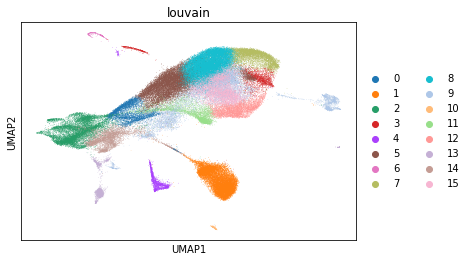

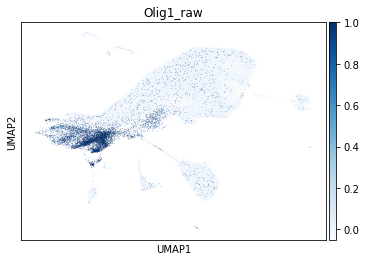

CPU times: user 1.76 s, sys: 828 ms, total: 2.59 s
Wall time: 1.87 s


In [49]:
%%time
sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [50]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 18.875590324401855


In [52]:
print("Full time: %s" % (time.time() - start_time))
# client.close()

NameError: name 'start' is not defined